In [1]:
# KIM NGUYEN - PROJECT 1- GROUP 6
# Question 3: What is more valuable to renters—having more bedrooms and bathrooms or having more square footage?
# Biases & Limitations

In [2]:
# Data Science
import pandas as pd
import numpy as np
import scipy.stats as st
import datetime as dt
from scipy.stats import linregress

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Constants
CLEAN_DATA_PATH = "data/data.csv"
FACILITY_COLUMN_NAMES = ["bathrooms", "bedrooms", "square_feet"]

In [4]:
# Read in the data.
df = pd.read_csv(CLEAN_DATA_PATH, low_memory=False)

In [5]:
df['date'] = pd.to_datetime(df['date'])
print(df.dtypes)

Unnamed: 0                      int64
id                              int64
bathrooms                     float64
bedrooms                      float64
fee                            object
price                         float64
square_feet                     int64
cityname                       object
state                          object
latitude                      float64
longitude                     float64
date                   datetime64[ns]
price_per_square_ft           float64
dtype: object


In [6]:
# Some city names occur in different states, thereby referring to different cities!
df.groupby('cityname').nunique().sort_values('state', ascending=False).head()

,Unnamed: 0,id,bathrooms,bedrooms,fee,price,square_feet,state,latitude,longitude,date,price_per_square_ft
cityname,,,,,,,,,,,,
Springfield,258,258,5,5,1,171,139,10,24,24,12,230
Oxford,18,18,6,5,1,17,15,7,7,7,5,17
Farmington,26,26,4,3,1,22,21,6,8,8,10,23
Windsor,10,10,3,3,1,10,10,6,7,7,3,10
Arlington,1571,1571,6,5,2,878,571,6,31,31,15,1344


In [7]:
def filter_city(df, state, city):
     # Creates a mask (Boolean Series) for rows where the 'cityname' and "state" columns matches the given city
    city_mask_s = df["cityname"] == city
    state_mask_s = df["state"] == state
    # Filters the DataFrame using both masks, selecting rows that satisfy both conditions
    city_df = df[city_mask_s & state_mask_s]
    return city_df

In [8]:
def linear_regression(df, x_col_name, y_col_name):
    # Extracting the independent (X) and dependent (y) variables
    x = df[x_col_name]
    y = df[y_col_name]
    if np.amax(x) == np.amin(x):
        # if only one row for the town OR if, e.g., all rows are 1-bathroom units,
        # we cannot do a regression
        intercept = slope = rvalue = np.nan
    else:
        slope, intercept, rvalue, _, _ = st.linregress(x, y)
    return {
        f'{x_col_name}_slope': slope,
        f'{x_col_name}_rvalue': rvalue,
        f'{x_col_name}_intercept': intercept,
    }

In [9]:
def get_city_results(df, state, city):
    # Step 1: Filter the DataFrame for the specified city and state
    city_df = filter_city(df, state, city)
    # Step 2: Initialize a results dictionary with the state and city name
    city_regression_results = {'state': state, 'cityname': city}
    # Step 3: Iterate over facility columns and perform linear regression for each facility column
    for col in FACILITY_COLUMN_NAMES:
        #Compute regression between the column (col) and price.
        col_results = linear_regression(city_df, col, 'price')
        #Updates the city_regression_results dictionary with the regression results
        city_regression_results.update(col_results)
    #Returns the complete dictionary, containing: The state and cityname.Regression results (slope, intercept, and correlation coefficient)
    #..for each column in FACILITY_COLUMN_NAMES.
    return city_regression_results

In [10]:
def get_all_st_cities(df):
    return df.groupby(['state', 'cityname']).first().index.to_flat_index()

In [11]:
regression_df = pd.DataFrame([get_city_results(df, st_city[0], st_city[1]) for st_city in get_all_st_cities(df)])
print(regression_df.shape)
regression_df.head()

(3549, 11)


,state,cityname,bathrooms_slope,bathrooms_rvalue,bathrooms_intercept,bedrooms_slope,bedrooms_rvalue,bedrooms_intercept,square_feet_slope,square_feet_rvalue,square_feet_intercept
0,AK,Anchorage,428.743590,0.541602,500.846154,142.816901,0.486843,756.190141,0.542000,0.709549,614.469897
1,AK,Eagle River,860.000000,1.000000,80.000000,430.000000,1.000000,510.000000,0.942982,1.000000,427.017544
2,AK,Fairbanks,238.333333,0.785714,1099.166667,422.500000,0.928571,330.000000,0.437611,0.987164,904.547153
3,AK,Soldotna,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AK,Wasilla,263.547170,0.711411,715.716981,204.900000,0.679534,654.900000,0.640176,0.981355,372.791575


In [12]:
regression_df.count().sort_values()

bathrooms_slope          1995
bathrooms_rvalue         1995
bathrooms_intercept      1995
bedrooms_slope           2206
bedrooms_rvalue          2206
bedrooms_intercept       2206
square_feet_slope        2446
square_feet_rvalue       2446
square_feet_intercept    2446
state                    3549
cityname                 3549
dtype: int64

In [13]:
avarage_regression_df = regression_df.mean(numeric_only=True).sort_values(ascending=False)
avarage_regression_df

bedrooms_intercept       894.561806
bathrooms_intercept      768.438882
bathrooms_slope          480.329922
square_feet_intercept    420.671162
bedrooms_slope           297.753229
square_feet_slope          1.033078
square_feet_rvalue         0.693910
bathrooms_rvalue           0.644840
bedrooms_rvalue            0.591038
dtype: float64

In [14]:
avarage_regression_df_dropna = regression_df.dropna().mean(numeric_only=True).sort_values(ascending=False)
avarage_regression_df_dropna

bedrooms_intercept       891.829137
bathrooms_intercept      759.044683
square_feet_intercept    575.248475
bathrooms_slope          490.249934
bedrooms_slope           324.670734
square_feet_slope          0.921991
square_feet_rvalue         0.745016
bathrooms_rvalue           0.648925
bedrooms_rvalue            0.610532
dtype: float64

In [15]:
def get_bar_data(serieskim, keywordkim):
    indiceskim = [i for i in serieskim.index.tolist() if keywordkim in i]
    filtered_series = serieskim.loc[indiceskim]
    return filtered_series

[]

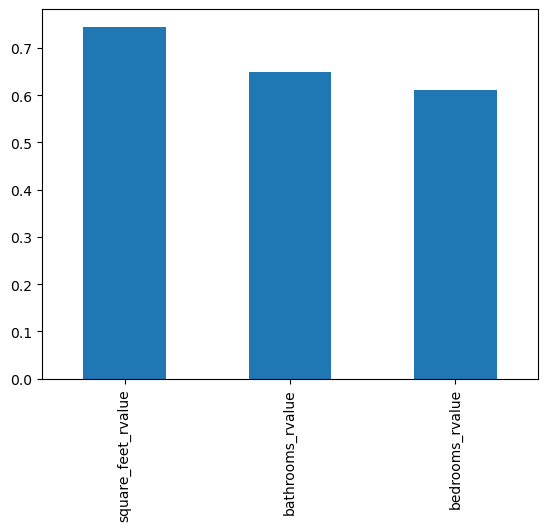

In [16]:
get_bar_data(avarage_regression_df_dropna, 'rvalue').plot(kind='bar')
plt.plot()

In [17]:
# correlations:
corrs=regression_df.corr(numeric_only=True)


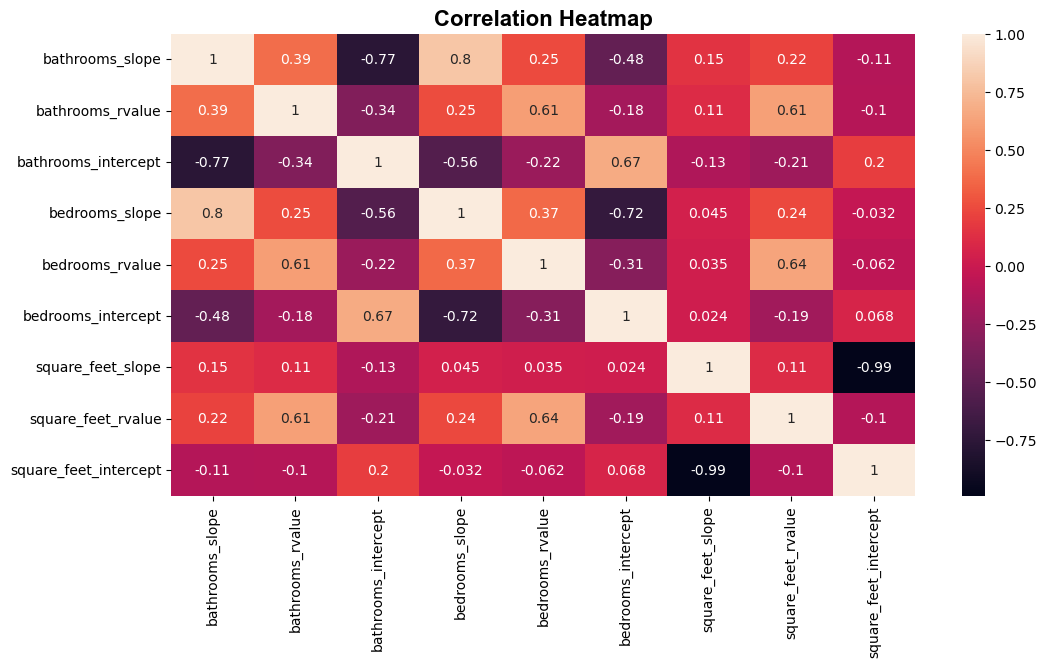

In [18]:

# Heatmap of correlations
# Change Canvas Size
plt.figure(figsize=(12, 6))

# Create a basic plot, anno (annatation the number on there)
sns.heatmap(corrs, annot=True)

# Customization
plt.title("Correlation Heatmap", fontweight="bold", fontsize=16, fontfamily="Arial")

# Show/Save the Graph
plt.show()

In [19]:
springfield_city_mask_s = regression_df['cityname'] == 'Springfield'
regression_df[springfield_city_mask_s]

,state,cityname,bathrooms_slope,bathrooms_rvalue,bathrooms_intercept,bedrooms_slope,bedrooms_rvalue,bedrooms_intercept,square_feet_slope,square_feet_rvalue,square_feet_intercept
1063,IL,Springfield,67.500000,0.180707,683.250000,88.983871,0.454940,589.145161,0.410275,0.529526,405.928731
1441,MA,Springfield,641.524476,0.641416,407.555944,218.881657,0.531981,776.284024,0.877497,0.729912,445.162211
1712,MI,Springfield,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1843,MO,Springfield,433.689410,0.614759,161.016743,0.748812,0.002183,680.522367,0.545713,0.519144,235.774941
2298,NJ,Springfield,631.387451,0.684086,1142.996442,442.859031,0.636911,1235.748899,1.308332,0.913845,807.401740
2638,OH,Springfield,143.014286,0.671755,496.607143,133.267544,0.714503,434.276316,0.465529,0.746188,282.571051
2743,OR,Springfield,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2850,PA,Springfield,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2998,TN,Springfield,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3352,VA,Springfield,352.000000,0.571984,1249.888889,264.651613,0.623713,1278.100000,0.970373,0.814990,859.555668


In [20]:
df.describe()

,Unnamed: 0,id,bathrooms,bedrooms,price,square_feet,latitude,longitude,date,price_per_square_ft
count,99004.000000,9.900400e+04,99004.000000,99004.000000,99004.000000,99004.000000,99004.000000,99004.000000,99004,99004.000000
mean,49754.808220,5.357983e+09,1.445861,1.728678,1525.582229,956.039746,36.941553,-91.544693,2019-06-03 17:20:34.131954432,1.682102
min,0.000000,5.121046e+09,1.000000,0.000000,100.000000,107.000000,19.573800,-159.369800,2018-12-07 00:00:00,0.047083
25%,24884.750000,5.197947e+09,1.000000,1.000000,1013.750000,730.000000,33.743500,-104.817100,2019-02-22 00:00:00,1.119929
50%,49677.500000,5.508672e+09,1.000000,2.000000,1350.000000,900.000000,37.213900,-84.546500,2019-09-17 00:00:00,1.468764
75%,74585.250000,5.509006e+09,2.000000,2.000000,1795.000000,1115.000000,39.955900,-77.576700,2019-09-17 00:00:00,2.000000
max,99491.000000,5.669439e+09,9.000000,9.000000,52500.000000,12000.000000,64.833200,-68.778800,2019-12-26 00:00:00,37.023977
std,28718.499936,1.846400e+08,0.547094,0.748669,898.693022,365.262997,4.603604,15.825449,NaN,0.851806


In [21]:
FACILITY_COLUMN_NAMES

['bathrooms', 'bedrooms', 'square_feet']

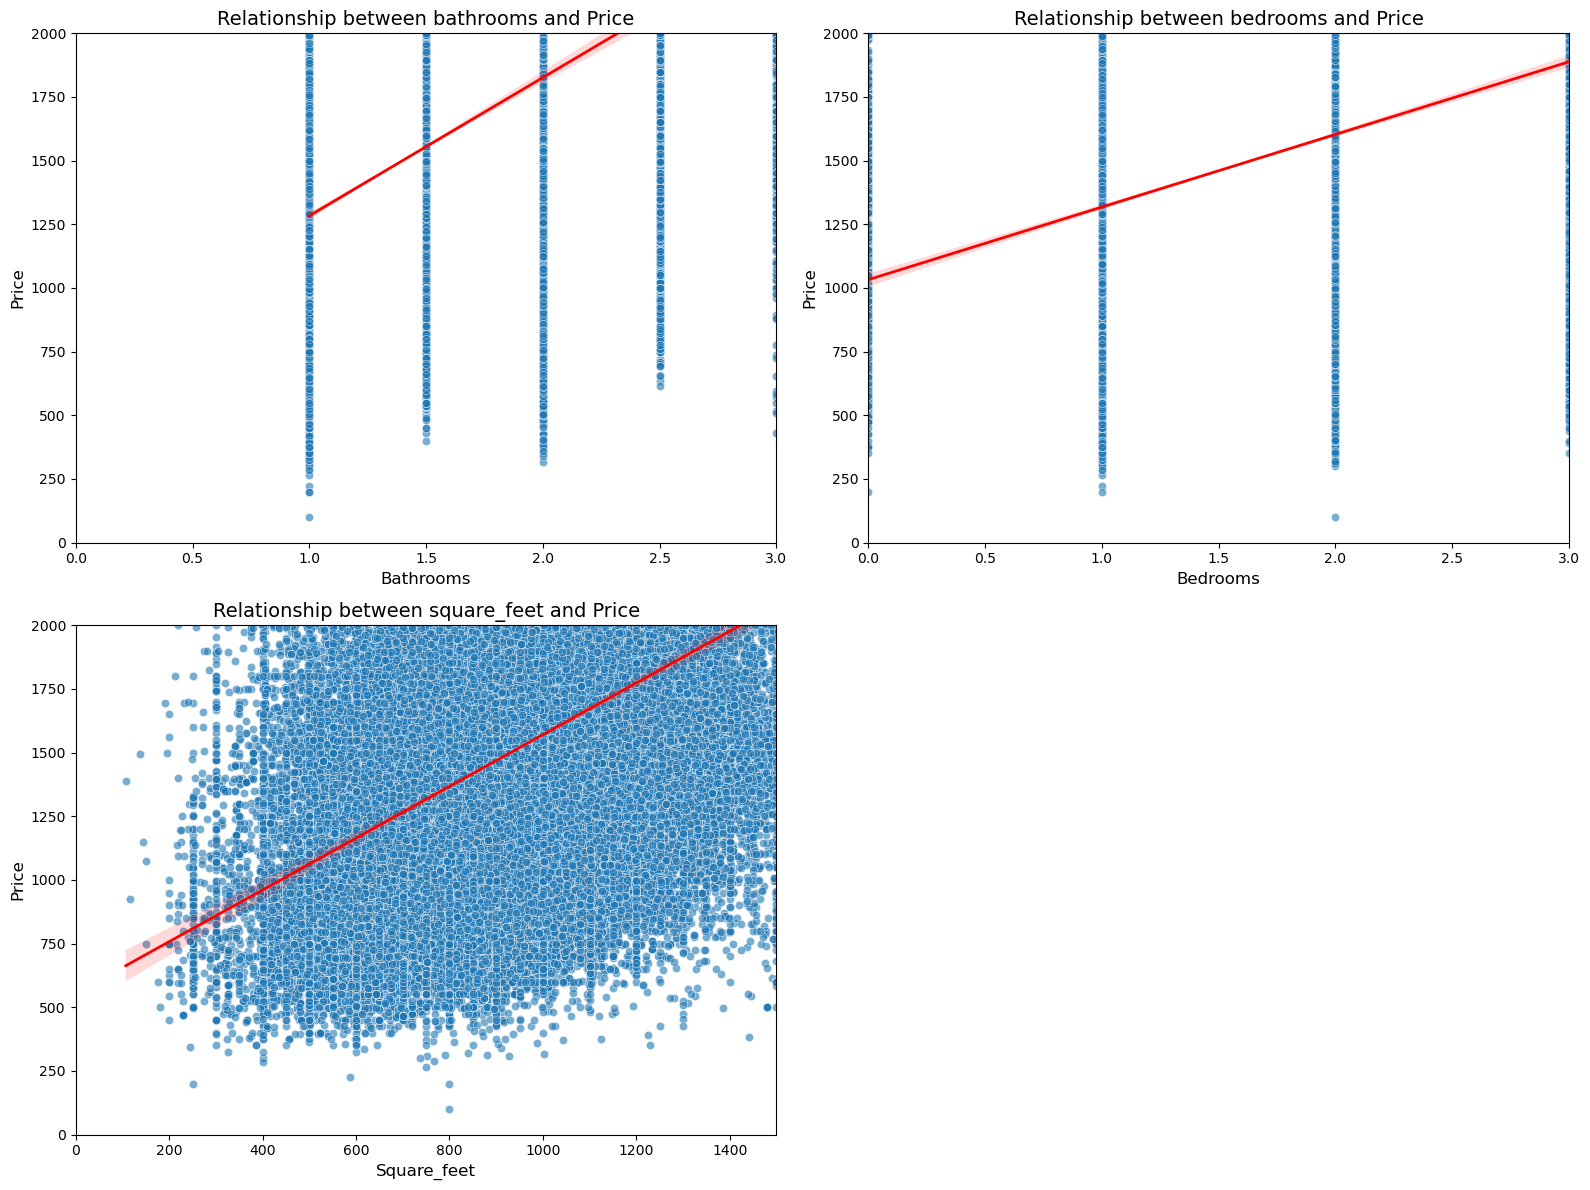

In [22]:
# Visualizing the effect of bathrooms, bedrooms, and square_feet on apartment prices

# Scatter plots for each feature vs. price
plt.figure(figsize=(16, 12))

for i, col in enumerate(FACILITY_COLUMN_NAMES, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(data= df, x=col, y='price', alpha=0.6)
    sns.regplot(data= df, x=col, y='price', scatter=False, color='red', line_kws={'linewidth': 2})
    plt.title(f'Relationship between {col} and Price', fontsize=14)
    plt.xlabel(col.capitalize(), fontsize=12)
    plt.ylabel('Price', fontsize=12)
    plt.ylim(0, 2000)
    if col =='square_feet': 
        plt.xlim(0, 1500)
    else:
        plt.xlim(0, 3)

plt.tight_layout()
plt.show()


In [23]:
# THIS JUST FOR BIAS AND LIMITATION: Define a function to determine the season
def get_season(date):
    if date.month in [12,1,2]:
        return "winter"
    elif date.month in [3,4,5]:
        return "Spring"
    elif date.month in [6,7,8]:
        return "Summer"
    else:
        return "Fall"
#create a new column for the season
df["season"] = df["date"].apply(get_season)

In [24]:
# Print column names to verify
print("Columns in DataFrame:", df.columns)

Columns in DataFrame: Index(['Unnamed: 0', 'id', 'bathrooms', 'bedrooms', 'fee', 'price',
       'square_feet', 'cityname', 'state', 'latitude', 'longitude', 'date',
       'price_per_square_ft', 'season'],
      dtype='object')


In [25]:
# Group by the season column and calculate the sum of values
grouped_season = df.groupby('season').size().reset_index()
grouped_season

,season,0
0,Fall,43154
1,Spring,358
2,Summer,934
3,winter,54558
